In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import matplotlib.pyplot as plt
import warnings

plt.rcParams["figure.figsize"] = (12, 4)

In [55]:
def x_data():
    x_data = pd.read_csv("../output_mo/combined_mo_data/a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [56]:
def y_data():
    y_data = pd.read_csv("../output_qt/combined_qt_data/a0_combinedQuarterly.csv", index_col=0)['gdp_total'].to_frame()

    first_date = y_data.index[0]
    y_data.index = pd.PeriodIndex(y_data.index, freq='Q')
    y_data['Date'] = y_data.index.to_timestamp()

    # convert to period
    y_data['Date'] = pd.to_datetime(y_data['Date']).dt.to_period('M')
    # set Date as index and resample
    y_data = y_data.set_index('Date').resample('M').interpolate()

    y_data.index = y_data.index.strftime('%Y-%m-%d')
    y_data.index = pd.date_range(first_date, y_data.index[-1], freq='MS').date
    return y_data

In [57]:
regressionData = y_data().merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv('../output_mo/regressiondata_mo/regressiondata_mo.csv')
df = regressionData.iloc[0:355,:].copy()

C:\Users\jpark\AppData\Local\Temp\ipykernel_19672\1142292460.py:11: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  y_data = y_data.set_index('Date').resample('M').interpolate()


C:\Users\jpark\AppData\Local\Temp\ipykernel_19672\3011322458.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['gdp_total_dirty'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']


<Axes: >

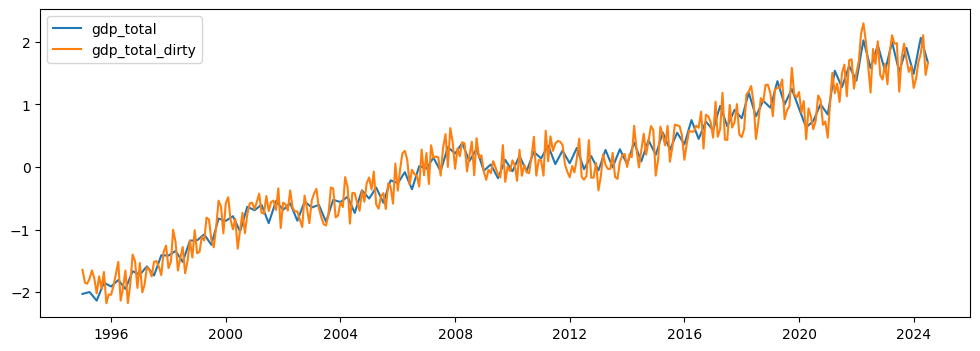

In [58]:
from sklearn.preprocessing import StandardScaler
import random


# subset of the data
df1 = df[['gdp_total', 
          '^AEX', 
          'EconomischeSituatieKomende12Maanden_5',
          'ProducerConfidence_1', 
          'Consumentenvertrouwen_1',
          'Crude oil, Brent', 
          'Coffee, Arabica', 
          'Gold', 
          'M3_1', 
          'M3_2',
          'CCICP_NLD_CLI', 
          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
          'Bankruptcies', 
          'FinancieleSituatieKomende12Maanden_7', 
          'Natural gas, Europe', 
          'CCICP_DEU', 
          'United States_unemply_M', 
          'Coconut oil',
          'BigBusinessInterestRate'
        ]]

# create a sure-fire predictor
df1['gdp_total_dirty'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# scale data to make comparable
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)

scaled_features_df[['gdp_total','gdp_total_dirty']].plot()


In [59]:
scaled_features_df.head()

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Netherlands_unemply_F,Netherlands_unemply_M,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil,BigBusinessInterestRate,gdp_total_dirty
1995-01-01,-2.028624,-1.777491,0.460059,0.796119,0.283872,-1.295229,0.447421,-1.019448,-1.621328,-1.665018,...,2.294188,1.032212,-0.197557,0.023051,-0.688984,-0.071206,0.433027,-0.776979,NaN,-1.643737
1995-02-01,-2.018752,-1.779647,0.725190,0.796119,0.550353,-1.281242,0.396151,-1.022687,-1.611303,-1.654293,...,2.600233,1.227644,-0.453562,0.323345,-0.688984,-0.118037,0.234800,-0.744028,NaN,-1.848175
1995-03-01,-2.008880,-1.825242,0.824614,0.729277,0.728007,-1.283418,0.570632,-1.013394,-1.618668,-1.662577,...,2.651241,1.292788,0.016480,0.473492,-0.690267,-0.036155,0.086131,-0.753442,NaN,-1.865173
1995-04-01,-1.999008,-1.797409,0.625766,0.796119,0.683594,-1.231820,0.479659,-0.998285,-1.619225,-1.663768,...,2.345196,1.032212,-0.348642,0.473492,-0.682569,0.048682,-0.012982,-0.784040,NaN,-1.785905
1995-05-01,-2.044738,-1.737717,0.658907,0.729277,0.728007,-1.240834,0.418299,-1.008137,-1.602799,-1.646114,...,2.447211,0.836780,-0.495530,0.398418,-0.682569,0.101385,-0.062539,-0.791101,NaN,-1.653593


[ 0  2  4  7 10 16 18 19]
['^AEX', 'ProducerConfidence_1', 'Crude oil, Brent', 'M3_1', 'Netherlands_unemply_F', 'United States_unemply_M', 'BigBusinessInterestRate', 'gdp_total_dirty']


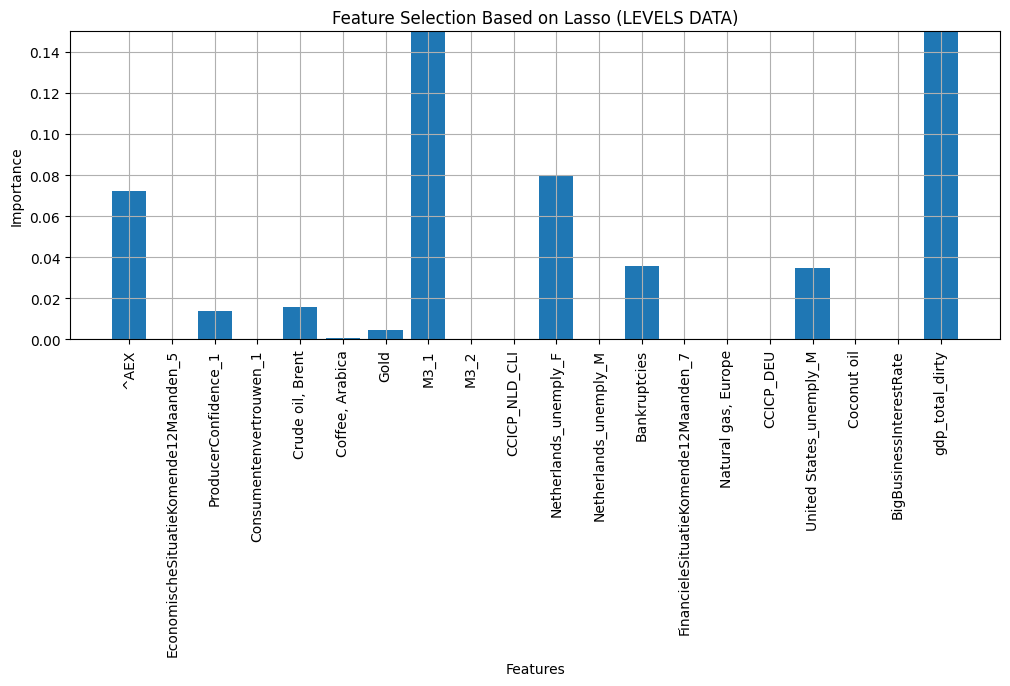

['^AEX',
 'ProducerConfidence_1',
 'Crude oil, Brent',
 'M3_1',
 'Netherlands_unemply_F',
 'United States_unemply_M',
 'BigBusinessInterestRate',
 'gdp_total_dirty']

In [60]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables


lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

[ 2  4  5 10 12 13 16 17 19]
['ProducerConfidence_1', 'Crude oil, Brent', 'Coffee, Arabica', 'Netherlands_unemply_F', 'Bankruptcies', 'FinancieleSituatieKomende12Maanden_7', 'United States_unemply_M', 'Coconut oil', 'gdp_total_dirty']


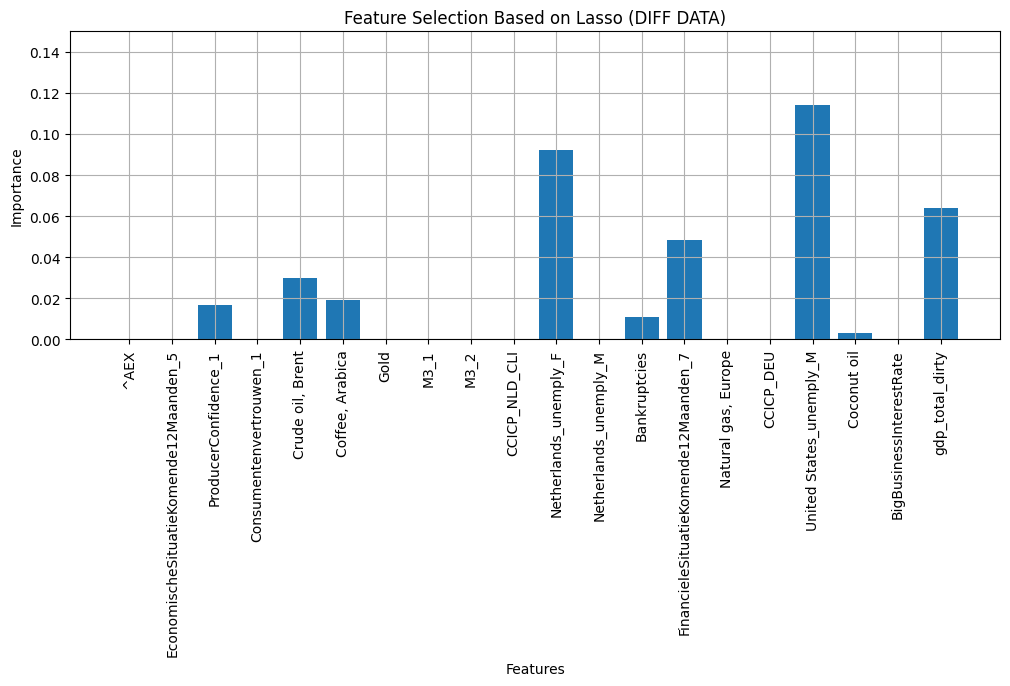

['ProducerConfidence_1',
 'Crude oil, Brent',
 'Coffee, Arabica',
 'Netherlands_unemply_F',
 'Bankruptcies',
 'FinancieleSituatieKomende12Maanden_7',
 'United States_unemply_M',
 'Coconut oil',
 'gdp_total_dirty']

In [61]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [62]:
scaled_features_df.head()

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Netherlands_unemply_F,Netherlands_unemply_M,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil,BigBusinessInterestRate,gdp_total_dirty
1995-01-01,-2.028624,-1.777491,0.460059,0.796119,0.283872,-1.295229,0.447421,-1.019448,-1.621328,-1.665018,...,2.294188,1.032212,-0.197557,0.023051,-0.688984,-0.071206,0.433027,-0.776979,NaN,-1.643737
1995-02-01,-2.018752,-1.779647,0.725190,0.796119,0.550353,-1.281242,0.396151,-1.022687,-1.611303,-1.654293,...,2.600233,1.227644,-0.453562,0.323345,-0.688984,-0.118037,0.234800,-0.744028,NaN,-1.848175
1995-03-01,-2.008880,-1.825242,0.824614,0.729277,0.728007,-1.283418,0.570632,-1.013394,-1.618668,-1.662577,...,2.651241,1.292788,0.016480,0.473492,-0.690267,-0.036155,0.086131,-0.753442,NaN,-1.865173
1995-04-01,-1.999008,-1.797409,0.625766,0.796119,0.683594,-1.231820,0.479659,-0.998285,-1.619225,-1.663768,...,2.345196,1.032212,-0.348642,0.473492,-0.682569,0.048682,-0.012982,-0.784040,NaN,-1.785905
1995-05-01,-2.044738,-1.737717,0.658907,0.729277,0.728007,-1.240834,0.418299,-1.008137,-1.602799,-1.646114,...,2.447211,0.836780,-0.495530,0.398418,-0.682569,0.101385,-0.062539,-0.791101,NaN,-1.653593


In [63]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty'] + selectThese 
df_lag = df[selectThese]

[ 0  1  2  9 21]
['gdp_total_dirty', 'gdp_total_lag_1', '^AEX_lag_1', 'M3_1_lag_1', 'gdp_total_dirty_lag_1']


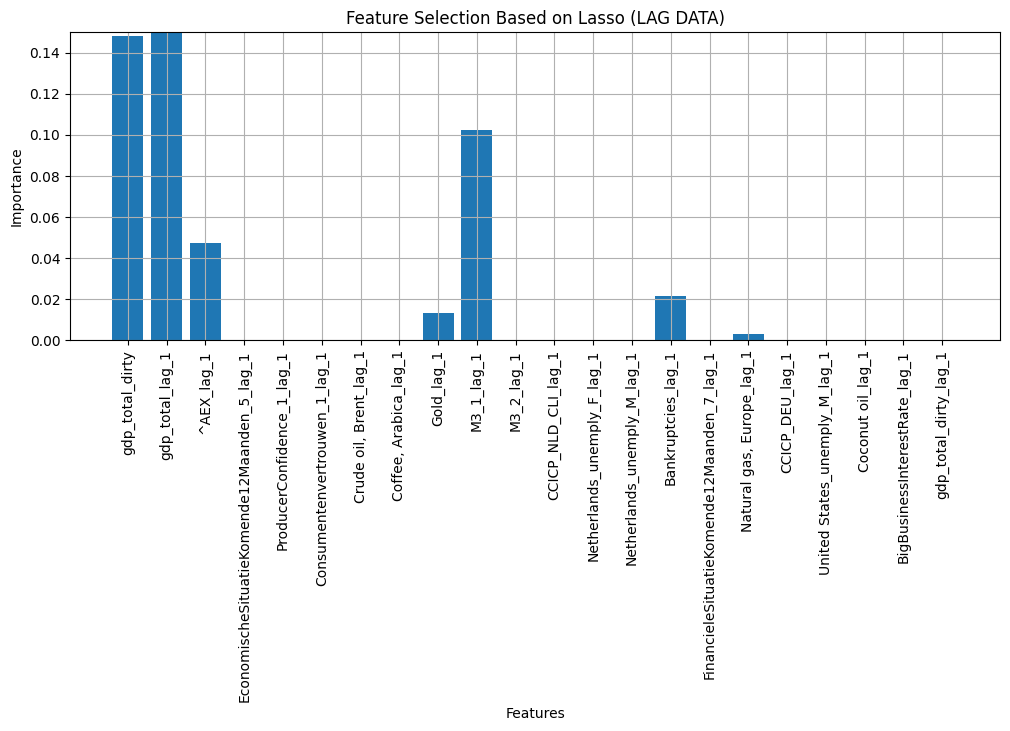

['gdp_total_dirty',
 'gdp_total_lag_1',
 '^AEX_lag_1',
 'M3_1_lag_1',
 'gdp_total_dirty_lag_1']

In [64]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  3  4  6 12 13 16 19 20 21]
['gdp_total_dirty', 'gdp_total_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'ProducerConfidence_1_lag_1', 'Crude oil, Brent_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'Natural gas, Europe_lag_1', 'Coconut oil_lag_1', 'BigBusinessInterestRate_lag_1', 'gdp_total_dirty_lag_1']


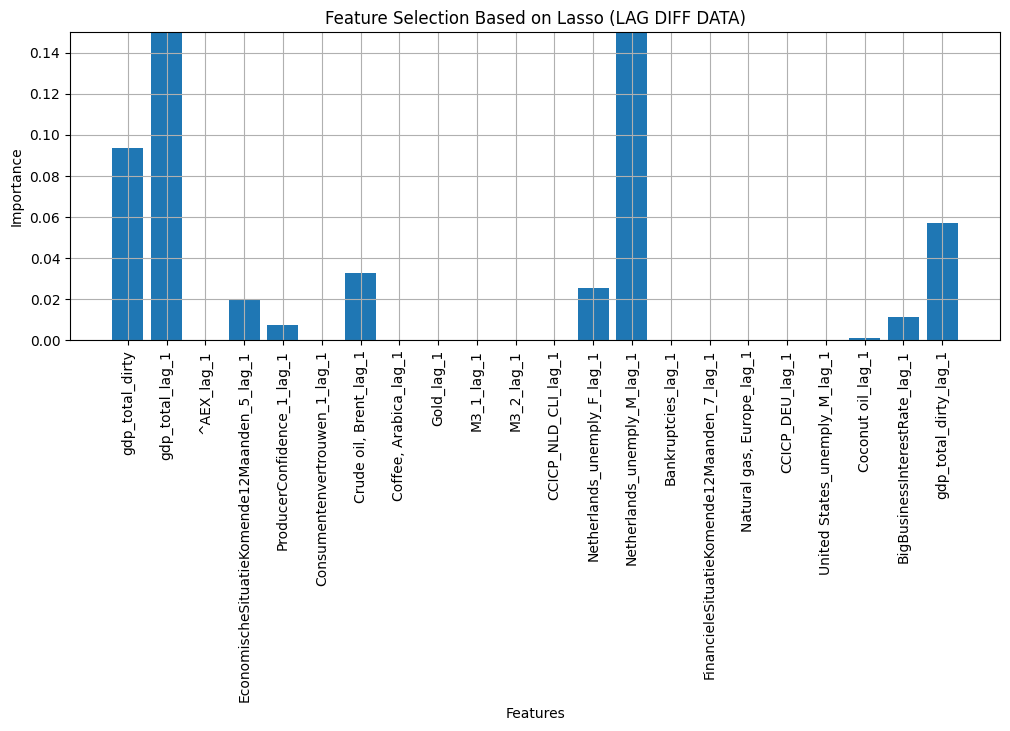

['gdp_total_dirty',
 'gdp_total_lag_1',
 'EconomischeSituatieKomende12Maanden_5_lag_1',
 'ProducerConfidence_1_lag_1',
 'Crude oil, Brent_lag_1',
 'Netherlands_unemply_F_lag_1',
 'Netherlands_unemply_M_lag_1',
 'Natural gas, Europe_lag_1',
 'Coconut oil_lag_1',
 'BigBusinessInterestRate_lag_1',
 'gdp_total_dirty_lag_1']

In [65]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 

### Make sure data is stationary

In [66]:

from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.stattools import adfuller

<Axes: >

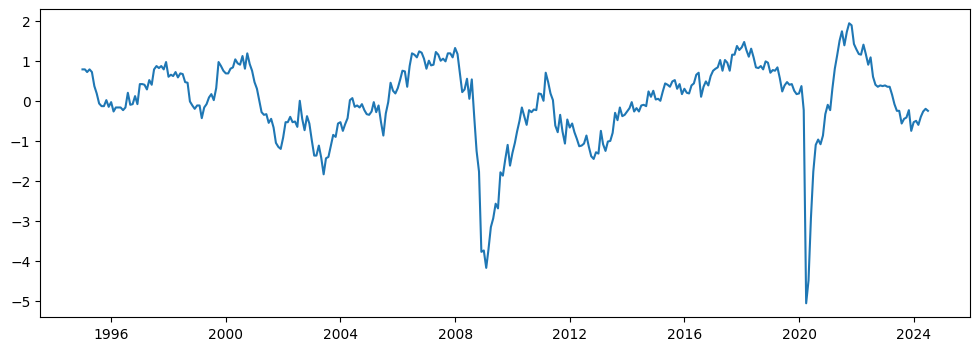

In [67]:
scaled_features_df['ProducerConfidence_1'].plot()

In [68]:
timeseries = scaled_features_df['ProducerConfidence_1']

In [69]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [70]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [74]:
stationary_features = []

for col in scaled_features_df.columns:
    print(col)

    timeseries = scaled_features_df[col].dropna()
    print(len(timeseries))

    adf1 = adf_test(timeseries, verbose=False)
    kpss1 = kpss_test(timeseries, verbose=False)
    if adf1 == "Stationary" and kpss1 == "Stationary":
        stationary_features.append(col)
    
stationary_features

gdp_total
355
^AEX
355
EconomischeSituatieKomende12Maanden_5
355
ProducerConfidence_1
355
Consumentenvertrouwen_1
355
Crude oil, Brent
355
Coffee, Arabica
355
Gold
355
M3_1
355
M3_2
355
CCICP_NLD_CLI
355
Netherlands_unemply_F
355
Netherlands_unemply_M
355
Bankruptcies
355
FinancieleSituatieKomende12Maanden_7
355
Natural gas, Europe
355
CCICP_DEU
355
United States_unemply_M
355
Coconut oil
355
BigBusinessInterestRate
259
gdp_total_dirty
355


C:\Users\jpark\AppData\Local\Temp\ipykernel_19672\458648093.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')
C:\Users\jpark\AppData\Local\Temp\ipykernel_19672\458648093.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')
C:\Users\jpark\AppData\Local\Temp\ipykernel_19672\458648093.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')
C:\Users\jpark\AppData\Local\Temp\ipykernel_19672\458648093.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
loo

['EconomischeSituatieKomende12Maanden_5',
 'ProducerConfidence_1',
 'Netherlands_unemply_M']